# Exp3: Recurrent Neural Network

基于训练好的词向量，编写RNN模型用于文本分类：分析文本情感是正面或者是负面

In [1]:
import collections
import os
import time
import random
import numpy as np
import pandas as pd
import jieba
import torch
from torch import nn
import torch.utils.data as Data

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_LAUNCH_BLOCKING"]="TRUE"
os.environ['CUDA_ENABLE_DEVICES'] = '0'

# torch.cuda.set_device(0)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(torch.__version__, device)
print(torch.version.cuda) 

1.10.0 cpu
10.2


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 20211129
setup_seed(seed)

## 1. 微博评论数据预处理

In [3]:
data_path = "weibo_senti_100k.csv"
df = pd.read_csv(data_path)

### 1.1 去除重复评论&停用词

In [4]:
#  (它们的 label 可能不一样)
df = df.drop_duplicates(subset=['label', 'review'], keep='first')
df = df.drop_duplicates(subset=['review'], keep=False).reset_index(drop=True)
df = df.sample

In [5]:
# 去除停用词
def stopwords_list():
    with open('哈工大停用词表.txt',encoding='utf-8') as f:
        lines = f.readlines()
        result = [i.strip('\n') for i in lines]
    return result
stopwords = stopwords_list()
stopwords.append('...')

review_list = []
for i in df['review'].map(lambda x: ' '.join(jieba.cut(x))):
    final=''
    for j in i.split():
        if j not in stopwords:
            final +=" "+str(j)
    review_list.append(final)
df['review'] = review_list

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ustc\AppData\Local\Temp\jieba.cache
Loading model cost 0.421 seconds.
Prefix dict has been built successfully.


In [6]:
df.head()

,label,review
0,1,﻿ 更博 爆照 帅 越来越 爱 生快 傻 缺 爱 爱 爱
1,1,张晓鹏 jonathan 土耳其 事要 认真对待 直接 开除 丁丁 看 世界 很 细心 酒...
2,1,姑娘 都 羡慕 … 招财猫 高兴 … … 爱 蔓延 JC 小 学徒 一枚 明天 见 李欣芸...
3,1,美 ~ ~ ~ ~ ~ 爱
4,1,梦想 大 舞台 大 ! 鼓掌


### 1.2 分词并创建词字典

In [7]:
def get_vocab(review_list):
    word_set = set()
    i = 0
    for x in review_list:
        word_set = word_set | set(x.split())
        if i % 10000 == 0:
            print("构建词集合 {}0k/116k".format(i//10000), end='\r')
        i += 1
    # 直接对每个词进行编号
    vocab = dict(zip(word_set, range(1,len(word_set)+1)))
    print('# words in vocab:', len(vocab))
    return vocab

In [8]:
# random.shuffle(review_list)
# vocab = get_vocab(review_list)

import  pickle
with open('vocab0_0.pickle', 'rb') as file:
    vocab = pickle.load(file)
print('# words in vocab:', len(vocab))

# words in vocab: 200542


### 1.3 长度规整

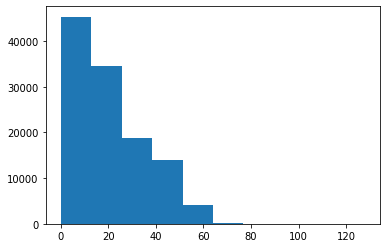

In [9]:
import matplotlib.pyplot as plt
len_review = [len(review.split()) for review in df.review]
plt.hist(len_review)
plt.show()

因为每条评论长度不一致所以不能直接组合成小批量，定义preprocess函数对每条评论通过词典转换成词索引。由评论长度(词数)分布图，可以将所有评论通过截断或者补0，将每条评论长度固定成50.

In [10]:
def preprocess(data, vocab):  
    max_l = 50  # 将每条评论通过截断或者补0，使长度得到统一

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))
    
    tokenized_data = [review.split() for review, _ in data]
    features = torch.tensor([pad([vocab[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([label for _, label in data])
    return features, labels

### 1.4 创建数据迭代器

In [11]:
train_df = df.sample(frac=0.7, replace=False, random_state=seed)
test_df = df.drop(index=train_df.index)
train_data = train_df[['review', 'label']].values.tolist()
test_data = test_df[['review', 'label']].values.tolist()
random.shuffle(train_data)
random.shuffle(test_data)
# del df, train_df, test_df

batch_size = 32
train_data = Data.TensorDataset(*preprocess(train_data, vocab))
test_data = Data.TensorDataset(*preprocess(test_data, vocab))   # 星号将返回的元组解开
train_iter = Data.DataLoader(train_data, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_data, batch_size)

打印第一个小批量数据的形状以及训练集中小批量的个数。

In [12]:
for X, y in train_iter:
#     print('X', X.shape, 'y', y.shape)
    print(X, y)
    break
print('#batches:', len(train_iter))

tensor([[  5406,  20650,      0,  ...,      0,      0,      0],
        [156070,  72011, 113260,  ...,  93679,  81067,  51217],
        [183362,   6479,  86765,  ...,      0,      0,      0],
        ...,
        [  6479, 132962,  20401,  ...,      0,      0,      0],
        [123254, 101384, 166360,  ...,      0,      0,      0],
        [129617, 154672, 149896,  ...,      0,      0,      0]]) tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1])
#batches: 2558


## 2. 使用RNN模型进行分类

### 2.1 网络搭建 

在这个模型中，每个词先通过嵌入层得到特征向量。然后，我们使用双向循环神经网络对特征序列进一步编码得到序列信息。最后，我们将编码的序列信息通过全连接层变换为输出。具体来说，我们可以将双向长短期记忆在最初时间步和最终时间步的隐藏状态连结，作为特征序列的表征传递给输出层分类。在下面实现的BiRNN类中，Embedding实例即嵌入层，LSTM实例即为序列编码的隐藏层，Linear实例即生成分类结果的输出层。

In [13]:
class BiRNN(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers,
                                bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.decoder = nn.Linear(4*num_hiddens, 2) 

    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        embeddings = self.embedding(inputs.permute(1, 0))
        print(inputs.shape, end=';')
        print(embeddings.shape, end=';')
        # rnn.LSTM只传入输入embeddings，因此只返回最后一层的隐藏层在各时间步的隐藏状态。
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(embeddings) # output, (h, c)
        print(outputs.shape, end=';')
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为
        # (批量大小, 4 * 隐藏单元个数)。
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.decoder(encoding)
        print(encoding.shape, end=';')
        print(outs.shape, end='\r')
        return outs

创建一个含两个隐藏层的双向循环神经网络。

In [14]:
embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)

### 2.2 训练并评价模型

定义验证函数与训练函数

In [17]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            print('batch:', batch_count+1)
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            print('y:',y.shape)
            print("y_hat:", y_hat.shape)
            l = loss(y_hat, y)
            break
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net, device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

开始训练模型

In [18]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

training on  cpu
batch: 1
y: torch.Size([32]));torch.Size([50, 32, 100]);torch.Size([50, 32, 200]);torch.Size([32, 400]);torch.Size([32, 2])
y_hat: torch.Size([32, 2])


KeyboardInterrupt: 

在做数据清洗之前试着跑了几次，测试集准确率基本都在0.93-0.94；  
由此可见以上的数据清洗工作还是很有成效的。  

下面看看使用预训练的词向量，效果是否能有提升。  
(估计使用预训练的词向量反而没那么好，因为这本身就是一个很简单的分类任务，第一代的错误率就只有 1% 了)

## 3. 改进方案 

### 3.1 使用预训练的词向量

从 https://github.com/Embedding/Chinese-Word-Vectors 选取微博词库(Word)，每个词对应一个预训练好的300维向量。

In [ ]:
def load_pretrained_vocab(words):
    vocab = {}
    with open("sgns.weibo.word", "r", encoding='utf-8') as f:
        line = f.readline()     # 跳过第一行
        line = f.readline()
        while line:
            strlist = line[:-2].split(' ')
            if strlist[0] in words:
                vocab[strlist[0]] = [float(s) for s in strlist[1:]]
            line = f.readline()
    print("vacab has been built successfully!")
    return vocab

In [ ]:
def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), len(list(glove_vocab.values())[0])) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
#             idx = pretrained_vocab.stoi[word]
            embed[i, :] = torch.Tensor(pretrained_vocab[word])
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words." % oov_count)
    return embed

In [ ]:
glove_vocab = load_pretrained_vocab(set(vocab.keys()))

embed_size, num_hiddens, num_layers = 300, 100, 2
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)
net.embedding.weight.data.copy_(load_pretrained_embedding(vocab, glove_vocab))
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它

lr, num_epochs = 0.01, 5
# 要过滤掉不计算梯度的embedding参数
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

竟然略有改善，但是区别不大。  

下面对原始数据多做一些清洗工作，看看结果如何。

### 3.2 数据深度清洗

In [ ]:
data_path = "weibo_senti_100k.csv"
df = pd.read_csv(data_path)
df = df.drop_duplicates(subset=['label', 'review'], keep='first')
df = df.drop_duplicates(subset=['review'], keep=False).reset_index(drop=True)

除了去除停用词（本身也包括一些特殊符号），再去掉网址，并对一些标点做合并。  
比如将“美\~\~\~\~”变为“美\~”

In [ ]:
import re
def data_clean(x):
    re_tag = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'  # HTML标签
    # r'[a-z]*[:.]+\S+'
    x = re.sub(re_tag, '', x, flags=re.MULTILINE)
    p_text = re.compile(u'[\u4E00-\u9FA5|\s\w]').findall(x)
    x = re.sub(r'[\d+___|_]', '', "".join(p_text))  # 去除特殊符号
    x = re.sub(",+", ",", x)  # 合并逗号
    x = re.sub("~+", "~", x)  # 合并 ~
    x = re.sub(" +", " ", x)  # 合并空格
    x = re.sub("[...|…|。。。]+", "...", x)  # 合并句号
    x = re.sub("-+", "--", x)  # 合并-
    x = re.sub("———+", "———", x)  # 合并-
    return x

In [ ]:
# 去除停用词
def stopwords_list():
    with open('哈工大停用词表.txt',encoding='utf-8') as f:
        lines = f.readlines()
        result = [i.strip('\n') for i in lines]
    return result
stopwords = stopwords_list()
stopwords.append('...')

review_list = []
for i in df['review']:
    i = data_clean(i)
    i = ' '.join(jieba.cut(i))
    final=''
    for j in i.split():
        if j not in stopwords:
            final +=" "+str(j)
    review_list.append(final)
df['review'] = review_list

In [ ]:
random.shuffle(review_list)
vocab = get_vocab(review_list)

In [ ]:
train_df = df.sample(frac=0.7, replace=False, random_state=seed)
test_df = df.drop(index=train_df.index)
train_data = train_df[['review', 'label']].values.tolist()
test_data = test_df[['review', 'label']].values.tolist()
# del df, train_df, test_df

batch_size = 64
train_data = Data.TensorDataset(*preprocess(train_data, vocab))
test_data = Data.TensorDataset(*preprocess(test_data, vocab))   # 星号将返回的元组解开
train_iter = Data.DataLoader(train_data, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_data, batch_size)

In [ ]:
for X, y in train_data:
    print('X', X.shape, 'y', y.shape)
    print(X, y)
    break
print('#batches:', len(train_iter))

In [ ]:
embed_size, num_hiddens, num_layers = 50, 100, 2
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)
# net.embedding.weight.data.copy_(load_pretrained_embedding(vocab, glove_vocab))
# net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它

lr, num_epochs = 0.001, 5
# 要过滤掉不计算梯度的embedding参数
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

我花了一下午都没解决这个错误，google，stackoverflow，github都找了，很多说版本问题，我重新卸载并安装了最新版的pytorch和cudatoolkit还是没解决，所以实在是没找到具体原因，心态有点崩，只好暂时放弃。  
本来还有一个想法的，暂时没有机会实现了，先记录一下：  
把所有的表情找出来，同时记录它对应的label，分别有多少次是出现在正面评论，多少次是出现在负面评论。  
虽然不知道具体应该如何指导网络的训练，但是直观上觉得这应该是情感分类中一个很重要的判断依据。